In [2]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Sub-Tropical Climate

The Sub-Tropical climate can be found along the coast of the Gulf of Mexico, parts of Texas, Louisiana and Florida have sub-tropical climate. This climate is characterized by a a warm and humid climate. The winters are very mild, where the average winter temperatures are around 11 degrees celcius. The summers are hot and humid with average temperatures of 28 degrees celcius. Rain falls throughout the year, averaging around 1500 mm per year. 

This well is situated near Tallahassee in Florida on a height of 14.25 meters. The well is part of the Floridan aquifer system and it is classified as an unconfined aquifer. The water in the well is between 3 and 4 meters below the ground surface. The lithology of the well is unknown.


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [3]:
map = folium.Map(location=[30.13, -84.50], zoom_start=6)
folium.Marker([30.39, -84.35], popup='Weather Station').add_to(map)
folium.Marker([30.13, -84.50], popup='Well').add_to(map);

In [4]:
map

### Importing Data

#### Crawfordville, Well 300740084293001
#### Groundwater series

In [7]:
height = 14.25 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Crawford_300740084293001.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [8]:
head

Date and Time
1967-01-31    10.037054
1967-02-28    10.072716
1967-03-31     9.924888
1967-04-30     9.786204
1967-05-31     9.584020
                ...    
2024-10-26     9.781632
2024-10-27     9.772488
2024-10-28     9.760296
2024-10-29     9.745056
2024-10-30     9.735912
Name: Value, Length: 1944, dtype: float64

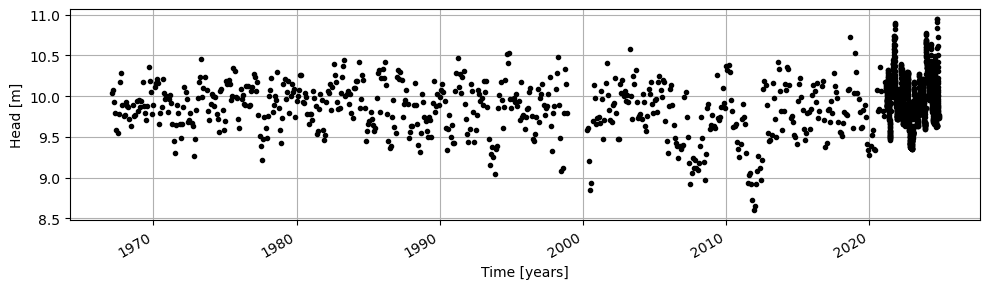

In [9]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [7]:
prec = pd.read_csv('Prec_temp/Tallahasse_3976539.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'PRCP'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

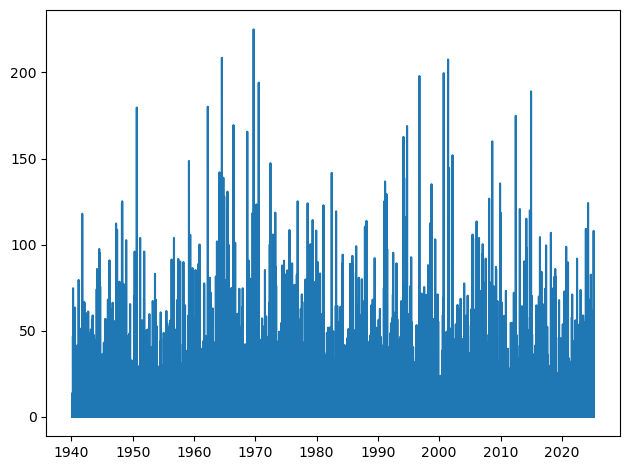

In [8]:
plt.plot(PRCP)

#### Evaporation

In [9]:
evap = pd.read_csv('Evap/Tallahasse.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'Hargreaves'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

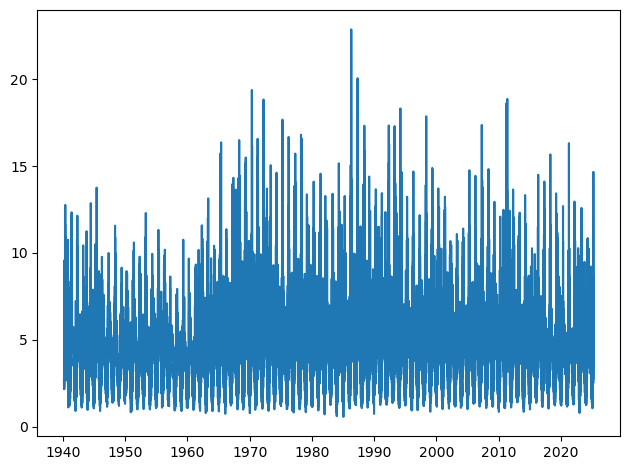

In [10]:
plt.plot(EPOT)

### Pastas Application

#### Resampling data for evenly spaced time steps

In [11]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

#### Basic Pastas Model

In [20]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    12                     EVP         41.46
nobs    1944                   R2           0.41
noise   False                  RMSE         0.23
tmin    1967-01-31 00:00:00    AICc     -5670.98
tmax    2024-10-30 00:00:00    BIC      -5643.15
freq    D                      Obj         52.30
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.122148   0.077687  True
rch_n        1.289337   1.000000  True
rch_a       34.211909  10.000000  True
rch_f       -0.730696  -1.000000  True
constant_d   9.803259   9.914402  True


[<Axes: xlabel='Date and Time', ylabel='Head'>,
 <Axes: xlabel='Date and Time'>,
 <Axes: title={'right': "Stresses: ['PRCP', 'Hargreaves']"}, xlabel='DATE', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=5)'}>]

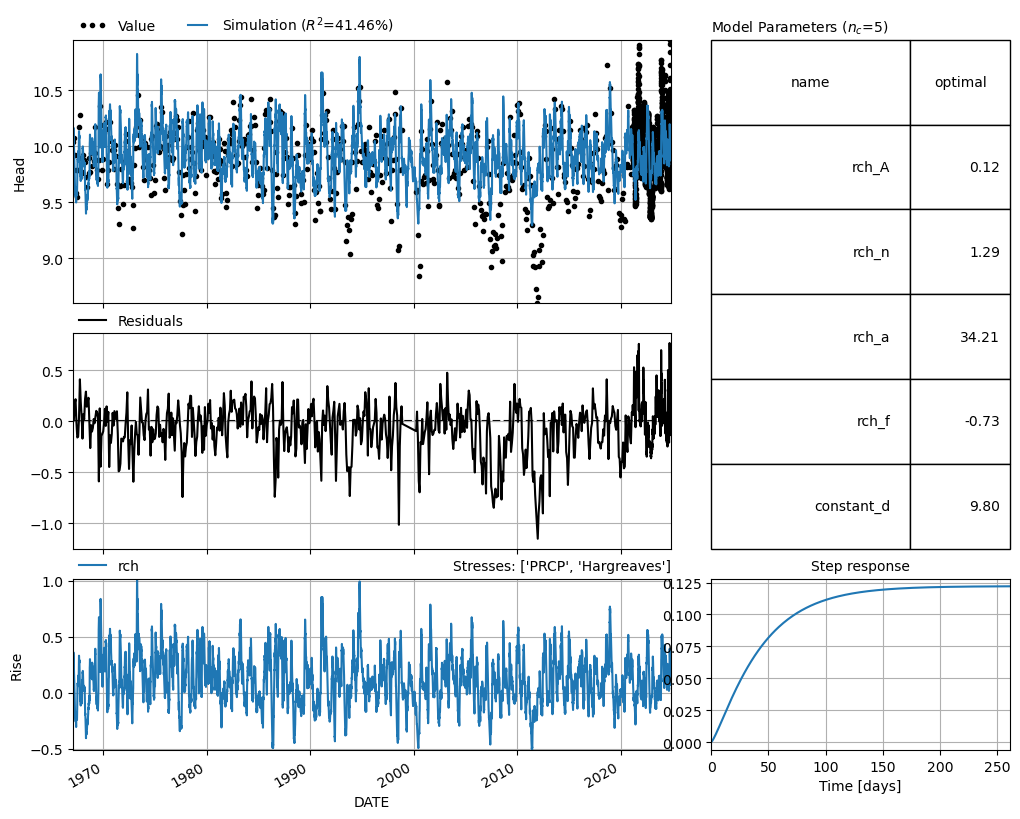

In [21]:
ml.plots.results()

#### Resample monthly

In [22]:
head_resampled = head.resample('M').last()

In [23]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    30                     EVP         56.18
nobs    675                    R2           0.56
noise   False                  RMSE         0.22
tmin    1967-01-31 00:00:00    AICc     -2063.66
tmax    2024-10-31 00:00:00    BIC      -2041.18
freq    D                      Obj         15.63
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.165743   0.077687  True
rch_n        1.767064   1.000000  True
rch_a       41.226157  10.000000  True
rch_f       -0.853109  -1.000000  True
constant_d   9.767214   9.838320  True


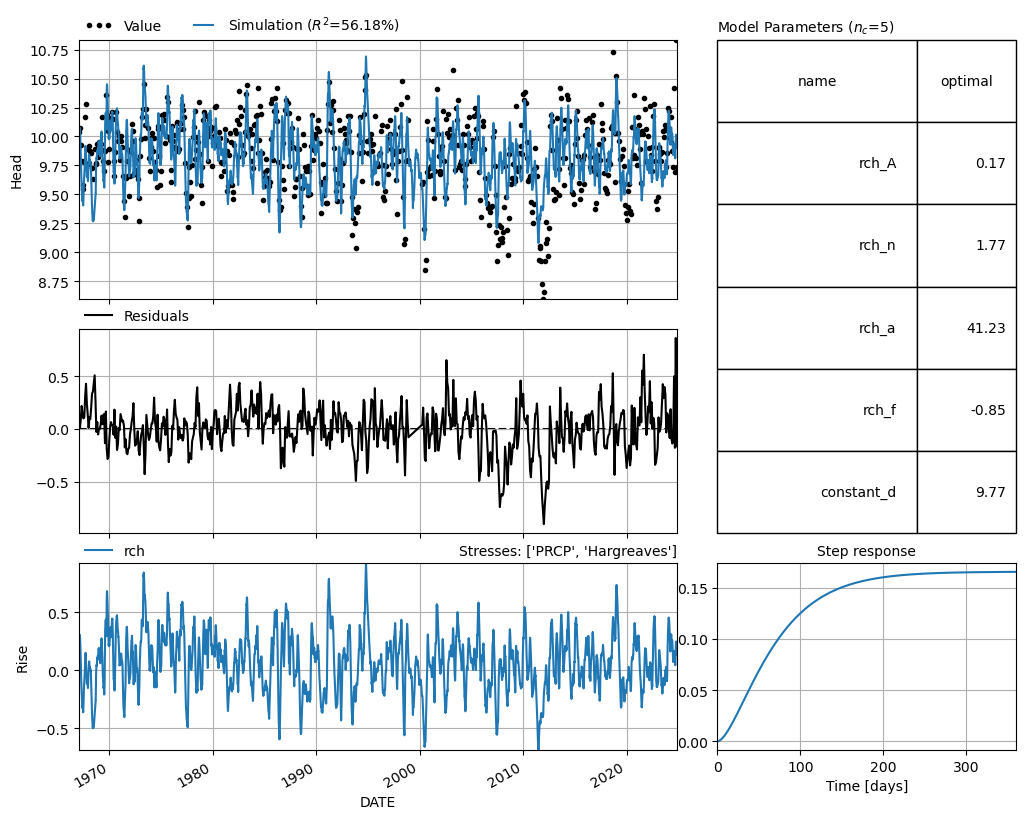

In [24]:
ml.plots.results();

#### Different recharge models and response functions

In [25]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    30                     EVP         56.18
nobs    675                    R2           0.56
noise   False                  RMSE         0.22
tmin    1967-01-31 00:00:00    AICc     -2063.66
tmax    2024-10-31 00:00:00    BIC      -2041.18
freq    D                      Obj         15.63
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.165743   0.077687  True
rch_n        1.767064   1.000000  True
rch_a       41.226157  10.000000  True
rch_f       -0.853109  -1.000000  True
constant_d   9.767214   9.838320  True


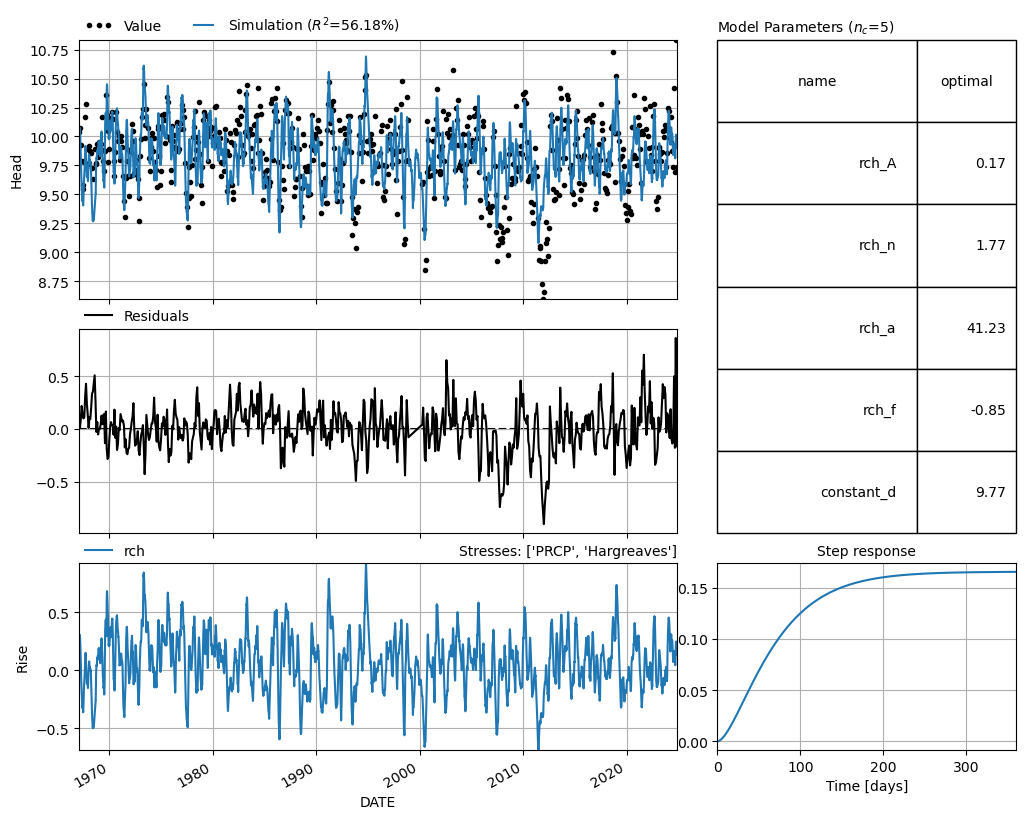

In [26]:
ml.plots.results();

In [28]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Berendrecht())
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    90                     EVP         47.17
nobs    675                    R2           0.47
noise   False                  RMSE         0.24
tmin    1967-01-31 00:00:00    AICc     -1933.42
tmax    2024-10-31 00:00:00    BIC      -1901.98
freq    D                      Obj         18.85
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
              optimal     initial   vary
rch_A        0.331749    0.344648   True
rch_n        1.942931    1.000000   True
rch_a       27.890376   10.000000   True
rch_fi       0.900000    0.900000  False
rch_fc       1.000000    1.000000  False
rch_sr       0.250000    0.250000  False
rch_de      88.829989  250.000000   True
rch_l       -3.434986    2.000000   True
rch_m        0.500000    0.500000  False
rch_ks      30.450641  100.000000   True
constant_d   9.072600    9.838320   True

Warnings! (1)
Parameter 'rch_m' on upper

In [29]:
ml2 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml2.add_stressmodel(sm)
ml2.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    43                     EVP         60.87
nobs    675                    R2           0.61
noise   False                  RMSE         0.20
tmin    1967-01-31 00:00:00    AICc     -2131.92
tmax    2024-10-31 00:00:00    BIC      -2091.56
freq    D                      Obj         13.96
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (9 optimized)
                 optimal    initial  vary
rch_A       3.345496e+00   0.517992  True
rch_n       9.398316e-01   1.000000  True
rch_a       6.488994e+01  10.000000  True
rch_scap    2.264864e+00   1.500000  True
rch_alpha   6.126234e-01   1.000000  True
rch_ksat    3.598309e-08   1.000000  True
rch_beta    6.871696e-02   0.500000  True
rch_gamma   1.999818e+00   1.000000  True
constant_d  7.965140e+00   9.838320  True


In [30]:
ml3 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml3.add_stressmodel(sm)
ml3.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    69                     EVP         56.28
nobs    675                    R2           0.56
noise   False                  RMSE         0.21
tmin    1967-01-31 00:00:00    AICc     -2061.12
tmax    2024-10-31 00:00:00    BIC      -2029.68
freq    D                      Obj         15.60
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
               optimal     initial   vary
rch_A         1.365168    0.228697   True
rch_n         1.121540    1.000000   True
rch_a        57.709086   10.000000   True
rch_srmax   106.922613  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks        1.412399  100.000000   True
rch_gamma     0.274176    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
constant_d    8.652507    9.838320   True


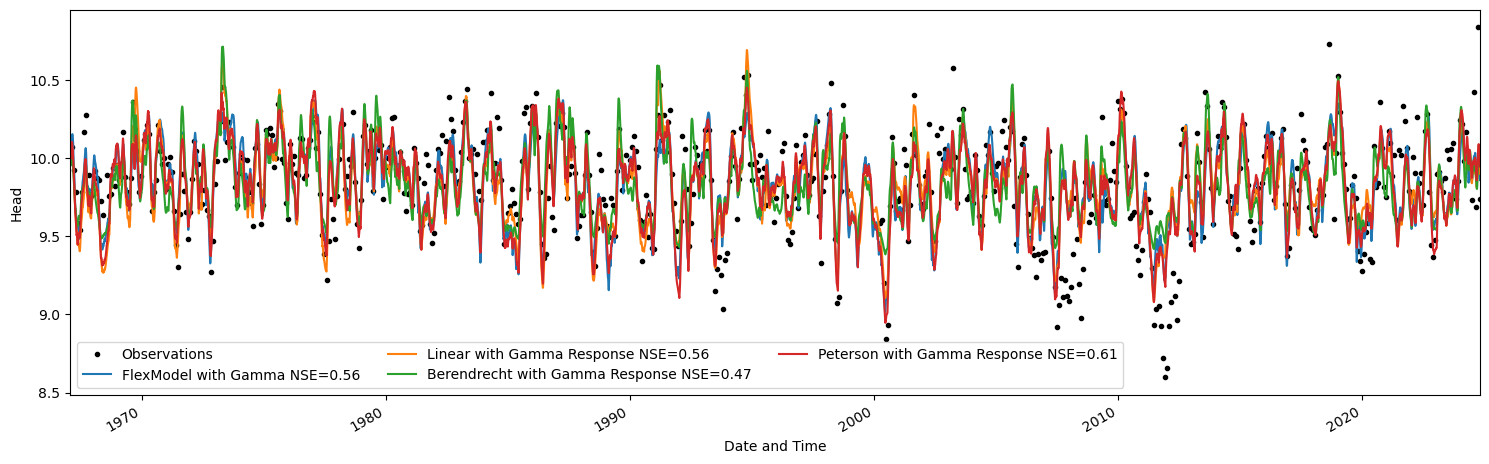

In [31]:
ax = ml3.plot(figsize=(15, 5))
ml.simulate().plot(ax=ax)
ml1.simulate().plot(ax=ax)
ml2.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma NSE={:.2f}".format(ml3.stats.nse()),
        "Linear with Gamma Response NSE={:.2f}".format(ml.stats.nse()),
        "Berendrecht with Gamma Response NSE={:.2f}".format(ml1.stats.nse()),
        "Peterson with Gamma Response NSE={:.2f}".format(ml2.stats.nse()),
    ],
    ncol=3,
)

#### Add Groundwater Uptake

As the groundwater is close to the surface, the gw_uptake feature can be applied

In [33]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    30                     EVP         57.32
nobs    675                    R2           0.57
noise   False                  RMSE         0.21
tmin    1967-01-31 00:00:00    AICc     -2075.36
tmax    2024-10-31 00:00:00    BIC      -2039.46
freq    D                      Obj         15.22
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (8 optimized)
               optimal     initial   vary
rch_A         0.191459    0.179762   True
rch_n         1.592254    1.000000   True
rch_a        46.766133   10.000000   True
rch_srmax   121.028130  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks       22.264126  100.000000   True
rch_gamma     0.315566    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
rch_gf        0.748531    1.000000   True
constant_d    9.719637    9.838320   True


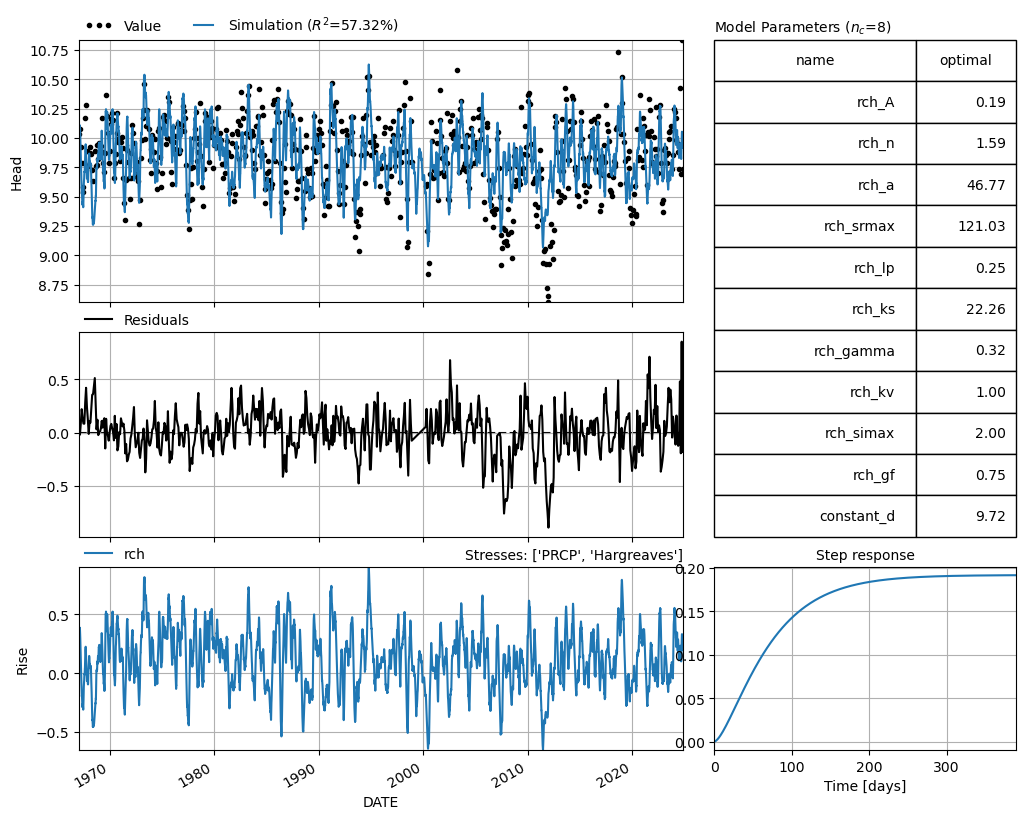

In [35]:
ml.plots.results();

In [36]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'Value': 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 36 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 33 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    69                     EVP         56.28
nobs    675                    R2           0.56
noise   False                  RMSE         0.21
tmin    1967-01-31 00:00:00    AICc     -2061.12
tmax    2024-10-31 00:00:00    BIC      -2029.68
freq    D                      Obj         15.60
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
               optimal     initial   vary
rch_A         1.365168    0.228697   True
rch_n         1.121540    1.000000   True
rch_a        57.709086   10.000000   True
rch_srmax   106.922613  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks        1.412399  100.000000   True
rch_gamma     0.274176    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
constant_d    8.652507    9.838320   True


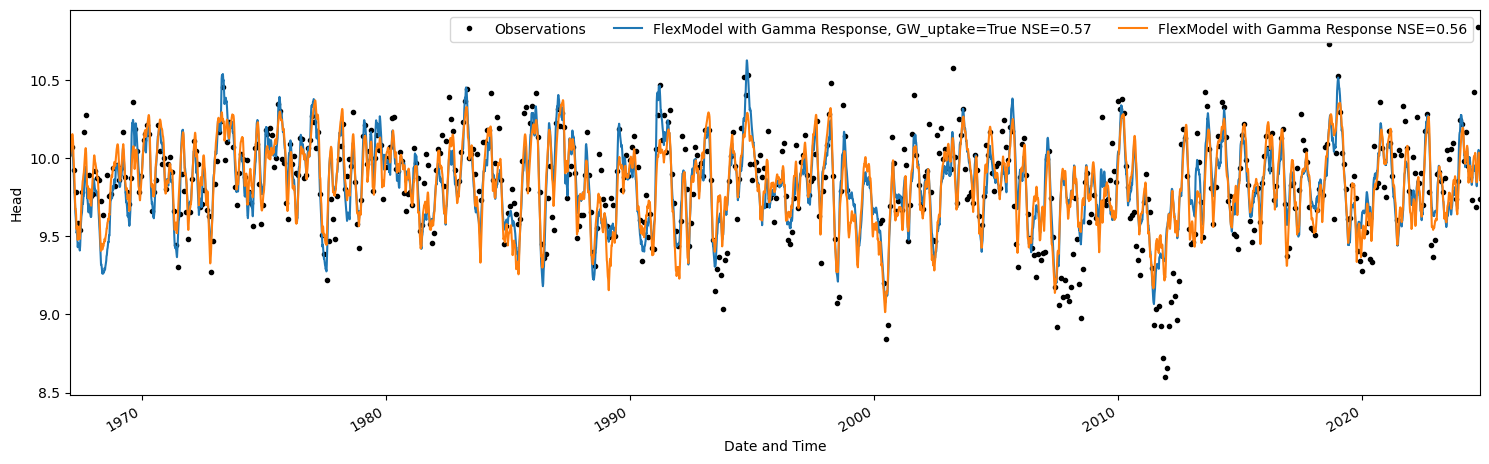

In [37]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma Response, GW_uptake=True NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Gamma Response NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)